# A comparison of backprojection with and without the ramp filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Some functions from radon-transform-demo

In [2]:
class Phantom2D:
    '''Class to handle input phantom and corresponding params. '''
    def __init__(self, M, dtype=np.uint8):
        self.M = M
        self.Ny, self.Nx = self.M.shape
        
def raytrace(phantom, phi, xi, dl=0.1):
    '''a function to retrieve a single line integral through a 2D matrix'''
    # initialize rotated P0, Pf (start and end points for ray)
    rotation_matrix = np.array([[np.cos(phi), -np.sin(phi)],
                                [np.sin(phi), np.cos(phi)]])
    P0 = rotation_matrix@np.array([xi, phantom.Nx])
    Pf = rotation_matrix@np.array([xi, -phantom.Nx])
    Px, Py = np.array([P0,Pf]).T + [phantom.Nx/2,phantom.Nx/2]
    P0, Pf = np.array([Px,Py]).T # shifted to phantom indexing (0->Nx, 0->Ny)
    
    # get evaluation points for line profile 
    points = []
    for n in range(-int(2*phantom.Nx/dl),int(2*phantom.Nx/dl)):
        point = P0 + n*dl*np.array([np.cos(phi+np.pi/2),np.sin(phi+np.pi/2)])
        if point[0]>0 and point[0]<phantom.Nx and point[1]>0 and point[1]<phantom.Ny:
            points.append(point)

    # calculate the line profile
    values = []
    for point in points:
        px, py = point
        ix, iy = int(px), int(phantom.Ny-py)
        values.append(phantom.M[iy,ix])
    
    return np.sum(values)*dl # line integral

def RT2D(phantom, Nxi=20, Nphi=20, plot_sino=True, get_sino=False):
    '''a function to calculate and show the 2D Radon Transform of a 2D matrix'''
    # make a sinogram
    N = np.min([phantom.Nx, phantom.Ny])
    xi_vals = np.linspace(-N/2+.1, N/2-.1, Nxi)  # bounds must be within +-N/2 !!
    phi_vals = np.linspace(0, 2*np.pi, Nphi)
    sino = np.zeros([len(phi_vals), len(xi_vals)])
    for i,xi in enumerate(xi_vals):
        for j,phi in enumerate(phi_vals):
            sino[j,i] = raytrace(phantom, phi, xi)
    if plot_sino:
        fig,ax=plt.subplots(1, 2, figsize=[6,3], dpi=100, facecolor='w')
        ax[0].imshow(phantom.M)
        ax[0].set_xlabel('$x$')
        ax[0].set_ylabel('$y$')
        ax[0].set_title('object $f(x,y)$')
        ax[1].imshow(sino, 
                  extent=(min(xi_vals),max(xi_vals), min(phi_vals),max(phi_vals)), 
                  aspect=(max(xi_vals)-min(xi_vals))/(max(phi_vals)-min(phi_vals)))
        ax[1].set_xlabel('$\\xi$')
        ax[1].set_ylabel('$\phi$')
        ax[1].set_title('sinogram $p(\\xi,\phi)$')
        fig.tight_layout()
        #plt.savefig('examples/sino.png')
        plt.show()
    if get_sino:
        return sino

# Read in our target image

(532, 535)
(266, 268)


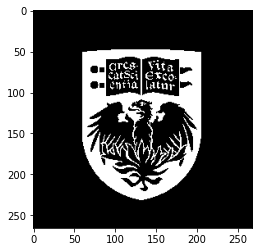

In [3]:
# read in an image
filename = 'imgs/uofc_crest.jpg' 
img = Image.open(filename)
data_rgb = np.asarray( img, dtype="int32" )
data = np.mean(data_rgb, axis=2)
    
# make binary, with cutoff 100
c=100
data[data<c] = 0.0
data[data>=c] = 1.0

while max(data.shape)>400:  # downsample to save run time
    data = data[::2,::2]
    print(data.shape)
    
plt.imshow(data, cmap='gray')    
plt.show()

crest = Phantom2D(data)

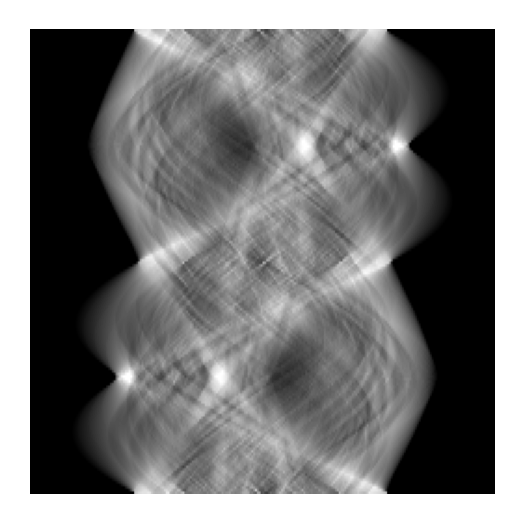

CPU times: user 152 ms, sys: 156 ms, total: 308 ms
Wall time: 103 ms


In [4]:
%%time

Nphi, Nxi = 180, 250
fname = f'imgs/sinogram_{Nphi}_{Nxi}.npy'
if os.path.isfile(fname):
    sino = np.fromfile(fname).reshape([Nphi,Nxi])
else: 
    # this takes 30+ min to run (depending on phantom size and sinogram resolution)
    sino = RT2D(crest, Nxi=Nxi, Nphi=Nphi, plot_sino=True, get_sino=True)
    sino.tofile(fname) # save for later
    
fig,ax=plt.subplots(1,1,dpi=300,figsize=[2,2*250/180])
ax.imshow(sino, cmap='gray', aspect=250/180)
ax.axis('off')
plt.show()

# 2D Backprojection

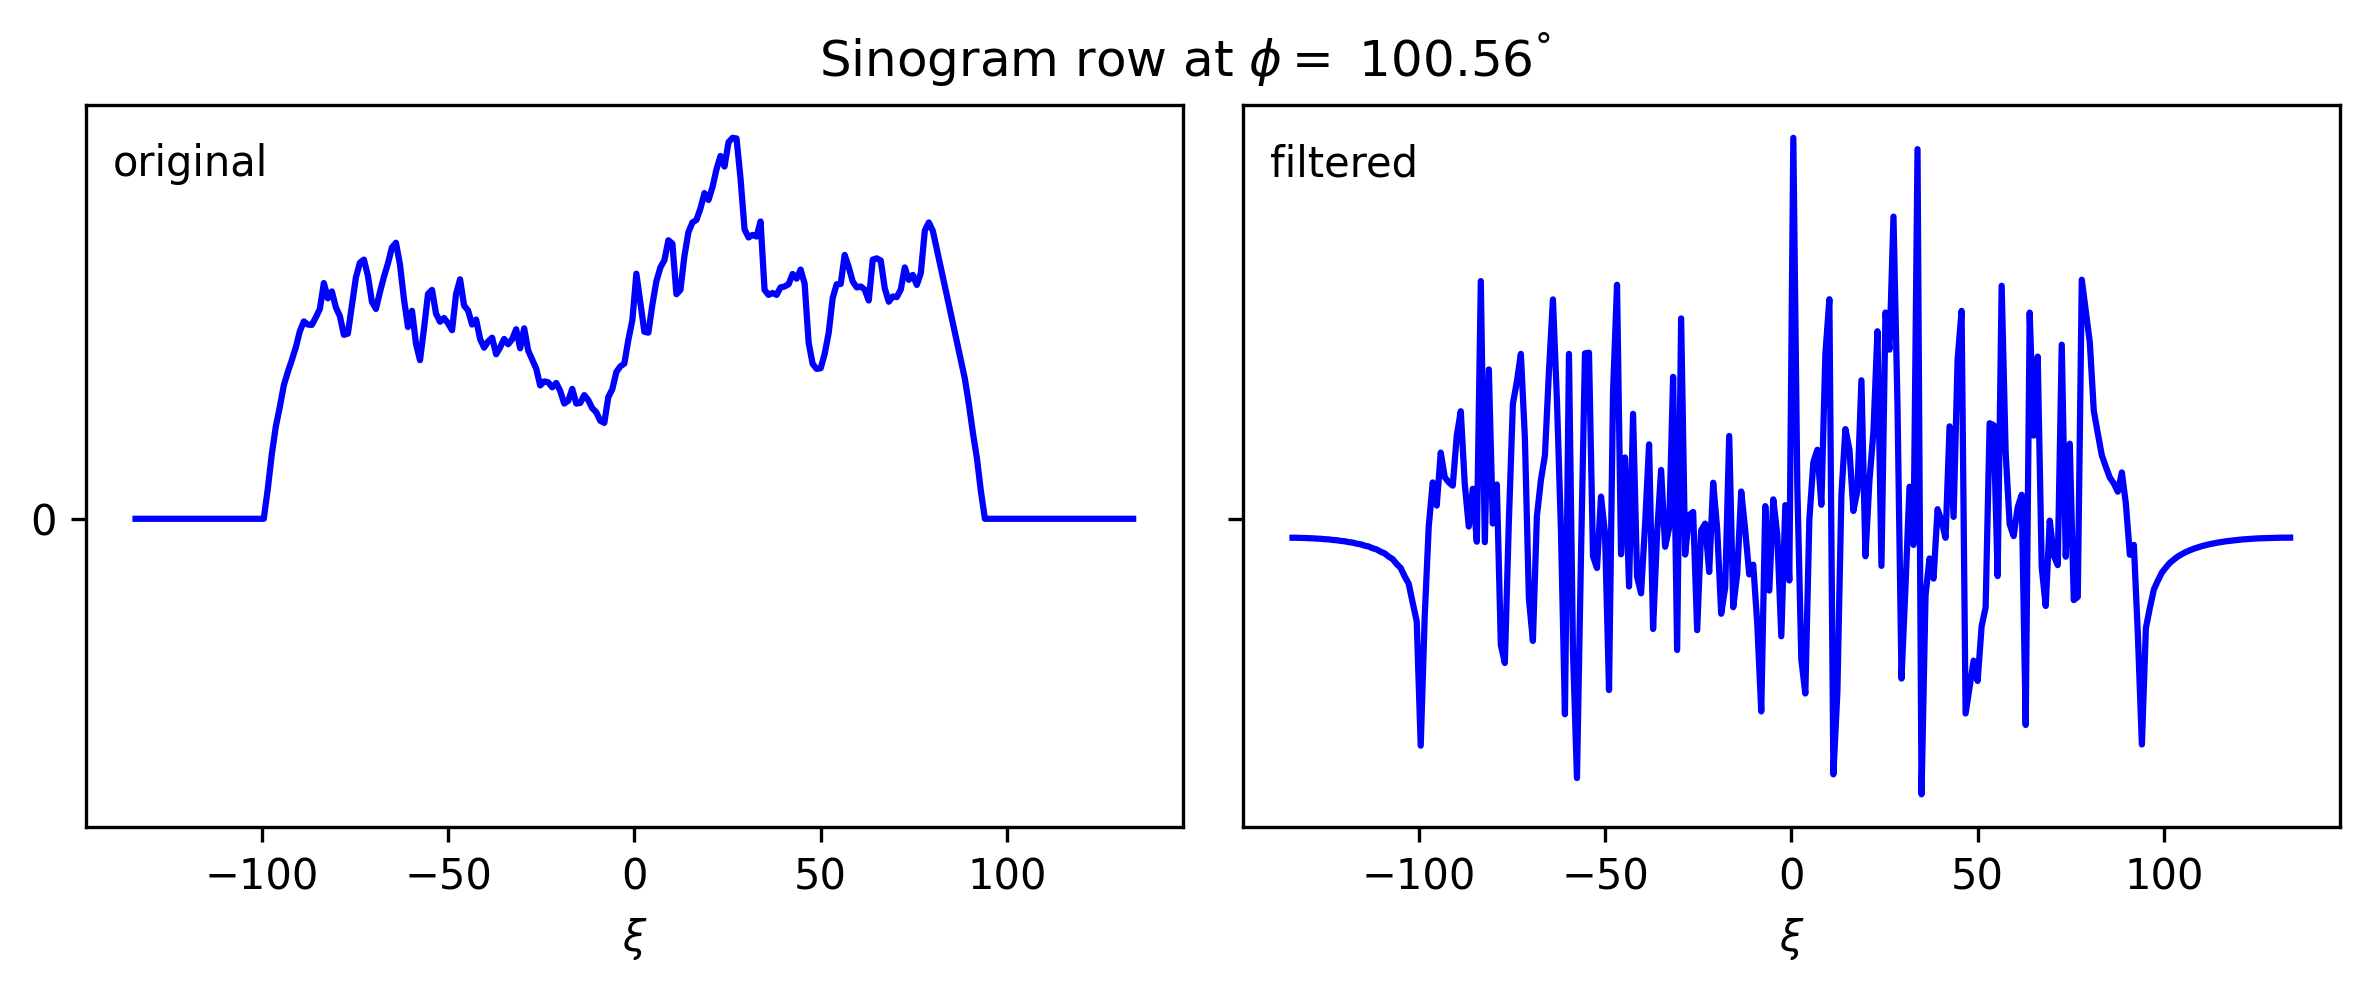

In [5]:
N = np.max(data.shape)
Nphi, Nxi = sino.shape
xi_vals = np.linspace(-N/2+.1, N/2-.1, Nxi) 
phi_vals = np.linspace(0, 2*np.pi, Nphi)

i_phi = 50 # arbitrary index for comparing a single row
phi = phi_vals[i_phi]
row_phi = sino[i_phi]

# filter using the ramp
freq_real = np.fft.rfftfreq(Nxi)
H = np.abs(freq_real)
row_phi_filt = np.fft.irfft(H*np.fft.rfft(row_phi)) 

fig,ax=plt.subplots(1,2,dpi=300,figsize=[8,3.5], sharey=True, facecolor='w')
fig.suptitle(f'Sinogram row at $\phi=$ {180*phi/np.pi:.2f}$^\degree$', y=0.93)
for axi in ax:
    axi.set_yticks([0])
    axi.set_xlabel('$\\xi$')
ax[0].plot(xi_vals, row_phi/np.max(row_phi), 'b-')
ax[0].text(-140,0.9,'original')
ax[1].plot(xi_vals, row_phi_filt/np.max(row_phi_filt), 'b-')
ax[1].text(-140,0.9,'filtered')
fig.tight_layout()
plt.savefig('examples/row_compare.png')
plt.show()


## Do backprojection with the original and filtered sinograms 

In [ ]:
%%time
M = np.zeros([N,N])
M_filt = np.zeros([N,N])
eta_0 = np.sqrt(N**2/2)

for i_phi,phi in enumerate(phi_vals):
    row_phi = sino[i_phi]
    row_phi_filt = np.fft.irfft(H*np.fft.rfft(row_phi)) 

    for i_xi, xi in enumerate(xi_vals):
        for i_eta, eta in enumerate(np.linspace(-eta_0, eta_0, 2*N)):
            x = xi*np.cos(phi) - eta*np.sin(phi)
            y = -(xi*np.sin(phi) + eta*np.cos(phi))
            i = int(x+N/2)
            j = int(y+N/2)
            if j>=0 and j<N and i>=0 and i<N:
                M[j,i]+=row_phi[i_xi]
                M_filt[j,i]+=row_phi_filt[i_xi]
                
    # save each frame for later
    M_filt.tofile(f'examples/frames/{i_phi:04}.npy')
            
c='gist_heat'
fig,ax=plt.subplots(1,2,dpi=300,figsize=[8,4],facecolor='w')
ax[0].imshow(M, cmap=c)
ax[0].set_title('unfiltered backprojection')
ax[1].imshow(M_filt,cmap=c)
ax[1].set_title('filtered backprojection')
for axi in ax:
    axi.axis('off')
fig.tight_layout()
#plt.savefig(f'examples/fbp_{i_eta+1}.png')
plt.show()

## Some step-by-step backprojection images

In [ ]:
import matplotlib.animation as animation

In [ ]:
# read in each frame (one frame per matrix)
img_dir = 'examples/frames/'
file_names = sorted([x for x in os.listdir(img_dir) if '.npy' in x])
the_mats0 = [np.fromfile(os.path.join(img_dir, f)).reshape([N,N]) for f in file_names]
the_mats = the_mats0[:len(the_mats0)//2+1] # take first half, redundant data
the_mats.append(the_mats0[-1]) # end on last image

# set up a figure
fig, ax = plt.subplots(1, 1, figsize=[6,6], dpi=150)
fig.set_tight_layout(True)  # optional, I like this
ax.axis('off')

# loop over all frames
ims = []
for i in range(len(the_mats)):
    im = ax.imshow(the_mats[i], animated=True, cmap='gist_heat')
    ims.append([im])
    
# save animation to .gif file
anim = animation.ArtistAnimation(fig, ims, interval=70, blit=True, repeat_delay=1000)
anim.save('examples/fbp_animation.gif', dpi=80, writer='imagemagick')

# show a frame
plt.show()

In [ ]:
# alternative figure: show side-by-side summation elements

d_mats0 = [the_mats0[i+1]-the_mats0[i] for i in range(len(the_mats0)-1)]

# set up a figure
fig, ax = plt.subplots(1, 2, figsize=[6,3], dpi=150)
fig.set_tight_layout(True)  # optional, I like this
for axi in ax:
    axi.axis('off')

# loop over all frames
ims = []
for i in range(len(d_mats0)):
    im0 = ax[0].imshow(the_mats0[i], animated=True, cmap='gist_heat')
    im1 = ax[1].imshow(d_mats0[i], animated=True, cmap='gist_heat',
                      vmax=0.5*np.max(d_mats0), vmin=0.5*np.min(d_mats0))
    ims.append([im0, im1])
    
# # save animation to .gif file
anim = animation.ArtistAnimation(fig, ims, interval=70, blit=True, repeat_delay=1000)
anim.save('examples/fbp_animation.gif', dpi=80, writer='imagemagick')

# show a frame
plt.show()